In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


In [3]:
real = pd.read_csv("F:\\F_Downloads\\True.csv")
fake = pd.read_csv("F:\\F_Downloads\\Fake.csv")

fake["label"] = 0   # Fake News
real["label"] = 1   # Real News
print(fake)

                                                   title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
0      Donald Trump just couldn t wish all Americans ...         News   
1      House Intelligence Committee Chairman Devin Nu...         News   
2      On Friday, it was revealed that former Milwauk...    

In [4]:
data = pd.concat([fake, real], axis=0)
data = data.sample(frac=1).reset_index(drop=True)  # Shuffle

# TEXT CLEANING

In [5]:
# Convert text to lowercase
data["text"] = data["text"].str.lower()

# Remove text inside square brackets
data["text"] = data["text"].str.replace(r'\[.*?\]', '', regex=True)

# Remove URLs
data["text"] = data["text"].str.replace(r'https?://\S+|www\.\S+', '', regex=True)

# Remove HTML tags
data["text"] = data["text"].str.replace(r'<.*?>+', '', regex=True)

# Remove punctuation
data["text"] = data["text"].str.replace(
    r'[{}]'.format(re.escape(string.punctuation)), '', regex=True
)

# Remove newline characters
data["text"] = data["text"].str.replace('\n', '', regex=True)

# Remove words containing numbers
data["text"] = data["text"].str.replace(r'\w*\d\w*', '', regex=True)

In [6]:
# Remove extra whitespaces
data["text"] = data["text"].str.replace(r'\s+', ' ', regex=True).str.strip()

# Exploratory Data Analysis [ EDA ]

C:\Users\DELL\AppData\Local\Temp\ipykernel_11576\3316794459.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=data, palette=["#4F81BD", "#C0504D"])


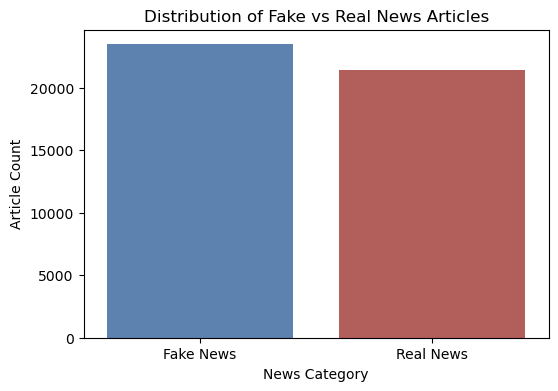

In [47]:
# Class Distribution (Business Reality Check)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=data, palette=["#4F81BD", "#C0504D"])
plt.xticks([0,1], ["Fake News", "Real News"])
plt.title("Distribution of Fake vs Real News Articles")
plt.xlabel("News Category")
plt.ylabel("Article Count")
plt.show()

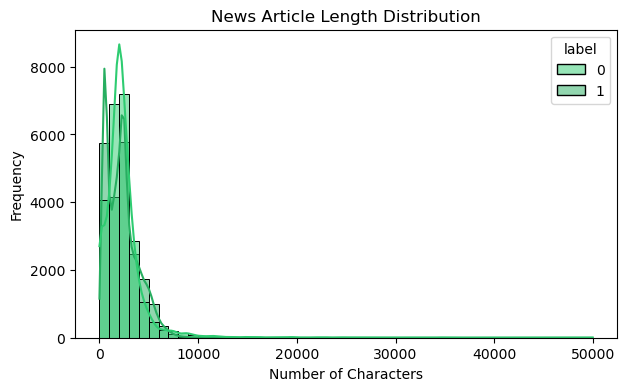

In [48]:
# Article Length Distribution (Model Design Insight)
data["text_length"] = data["text"].apply(len)

plt.figure(figsize=(7,4))
sns.histplot(
    data=data,
    x="text_length",
    hue="label",
    bins=50,
    palette=["#2ECC71", "#27AE60"],
    kde=True
)

plt.title("News Article Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_11576\2946731280.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\DELL\AppData\Local\Temp\ipykernel_11576\2946731280.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


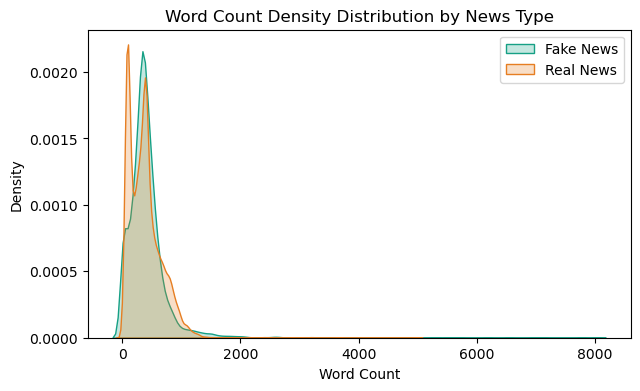

In [55]:
# Word Count Density (KDE Plot)
plt.figure(figsize=(7,4))

sns.kdeplot(
    data=data[data["label"] == 0]["word_count"],
    shade=True,
    color="#16A085",
    label="Fake News"
)

sns.kdeplot(
    data=data[data["label"] == 1]["word_count"],
    shade=True,
    color="#E67E22",
    label="Real News"
)

plt.title("Word Count Density Distribution by News Type")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.legend()
plt.show()

In [50]:
# Most Common Words (After Cleaning)
from collections import Counter

fake_words = Counter(" ".join(data[data["label"]==0]["text"]).split()).most_common(10)
real_words = Counter(" ".join(data[data["label"]==1]["text"]).split()).most_common(10)

fake_df = pd.DataFrame(fake_words, columns=["Word", "Count"])
real_df = pd.DataFrame(real_words, columns=["Word", "Count"])

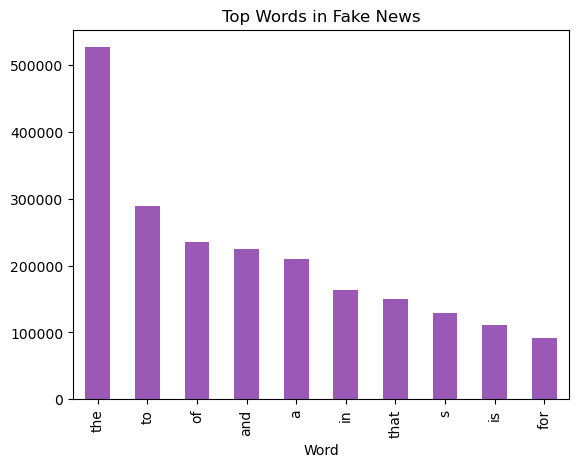

In [51]:
fake_df.plot(
    x="Word",
    y="Count",
    kind="bar",
    color="#9B59B6",
    legend=False,
    title="Top Words in Fake News"
)
plt.show()

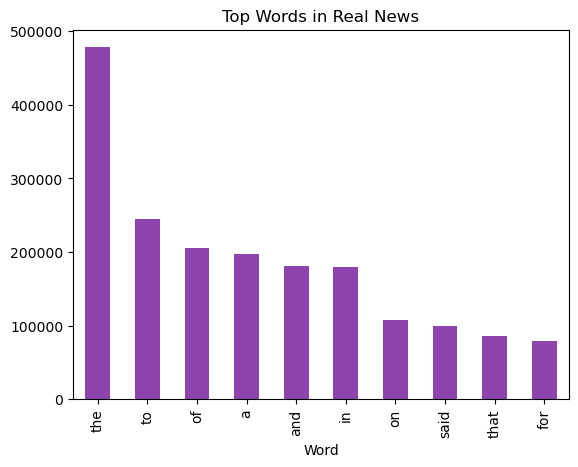

In [52]:
real_df.plot(
    x="Word",
    y="Count",
    kind="bar",
    color="#8E44AD",
    legend=False,
    title="Top Words in Real News"
)
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_11576\2546722116.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


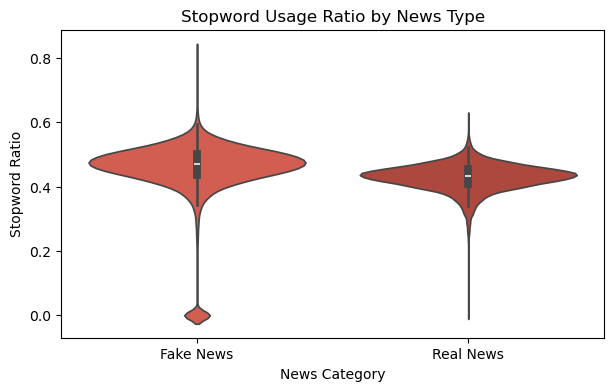

In [53]:
#Stopword Impact Check (Smart NLP Thinking
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

data["stopword_ratio"] = data["text"].apply(
    lambda x: sum(1 for word in x.split() if word in ENGLISH_STOP_WORDS) / max(len(x.split()),1)
)

plt.figure(figsize=(7,4))
sns.violinplot(
    x="label",
    y="stopword_ratio",
    data=data,
    palette=["#E74C3C", "#C0392B"]
)

plt.xticks([0,1], ["Fake News", "Real News"])
plt.title("Stopword Usage Ratio by News Type")
plt.xlabel("News Category")
plt.ylabel("Stopword Ratio")
plt.show()

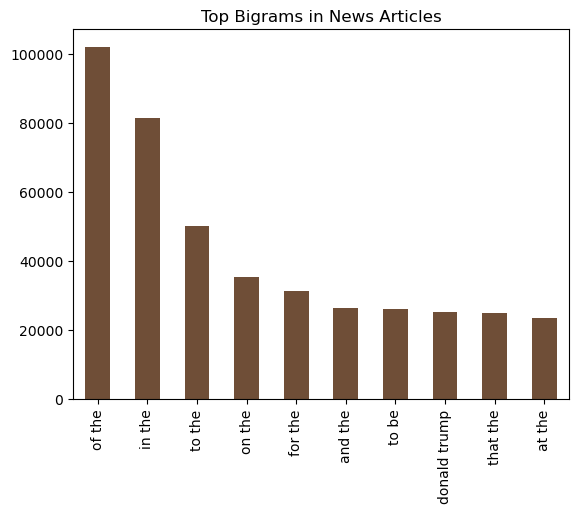

In [54]:
#N-Gram Frequency (Modern NLP EDA)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    ngram_range=(2,2),
    max_features=10
)

X_bigrams = vectorizer.fit_transform(data["text"])
bigram_freq = X_bigrams.sum(axis=0)

bigram_df = pd.DataFrame(
    bigram_freq.A1,
    index=vectorizer.get_feature_names_out(),
    columns=["Frequency"]
)

bigram_df.sort_values(by="Frequency", ascending=False).plot(
    kind="bar",
    color="#6F4E37",
    legend=False,
    title="Top Bigrams in News Articles"
)
plt.show()

# Feature & Label Split

In [7]:
X = data["text"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# TF-IDF Vectorization

In [8]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1,2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression

In [9]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

lr_pred = lr_model.predict(X_test_tfidf)

In [10]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

Logistic Regression Accuracy: 0.9874387527839643
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5832
           1       0.98      0.99      0.99      5393

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



# Naive Bayes

In [11]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

nb_pred = nb_model.predict(X_test_tfidf)

In [12]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))

Naive Bayes Accuracy: 0.9344320712694878
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5832
           1       0.93      0.93      0.93      5393

    accuracy                           0.93     11225
   macro avg       0.93      0.93      0.93     11225
weighted avg       0.93      0.93      0.93     11225



# Linear SVM

In [14]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

svm_pred = svm_model.predict(X_test_tfidf)

In [15]:
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

SVM Accuracy: 0.9944766146993318
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5832
           1       0.99      0.99      0.99      5393

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



# Random Forest (Ensemble Learning)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)

In [18]:
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.9967037861915368
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5832
           1       1.00      1.00      1.00      5393

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



# Model Comparison & Justification

In [19]:
model_results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Naive Bayes",
        "Linear SVM",
        "Random Forest"
    ],
    "Accuracy": [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, nb_pred),
        accuracy_score(y_test, svm_pred),
        accuracy_score(y_test, rf_pred)
    ]
})

print(model_results)

                 Model  Accuracy
0  Logistic Regression  0.987439
1          Naive Bayes  0.934432
2           Linear SVM  0.994477
3        Random Forest  0.996704


# Hyperparameter Tuning (Production Mindset)

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10],
    "penalty": ["l2"]
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

,estimator,LogisticRegre...max_iter=1000)
,param_grid,"{'C': [0.1, 1, ...], 'penalty': ['l2']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [22]:
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'C': 10, 'penalty': 'l2'}


# Handle Class Imbalance

In [23]:
print(data["label"].value_counts())

label
0    23481
1    21417
Name: count, dtype: int64


In [24]:
# Use Class Weights
lr_balanced = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr_balanced.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# Cross-Validation (Reliability Check)

In [25]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_model,
    X_train_tfidf,
    y_train,
    cv=5,
    scoring="f1"
)


In [26]:
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1:", cv_scores.mean())

Cross-validation F1 scores: [0.98957198 0.99065421 0.99032459 0.9932844  0.99140222]
Mean F1: 0.9910474804058891


# Explainability

In [28]:
# Top Words Influencing Fake vs Real News
feature_names = vectorizer.get_feature_names_out()
coefficients = best_model.coef_[0]

top_real = np.argsort(coefficients)[-10:]
top_fake = np.argsort(coefficients)[:10]

print("Top Real News Words:")
print(feature_names[top_real])

Top Real News Words:
['friday' 'nov' 'tuesday' 'washington' 'wednesday' 'reuters president'
 'president donald' 'washington reuters' 'said' 'reuters']


In [29]:
print("Top Fake News Words:")
print(feature_names[top_fake])

Top Fake News Words:
['just' 'image' 'gop' 'president trump' 'mr' 'hillary' 'president obama'
 'sen' 'rep' 'wire']


# Error Analysis

In [30]:
misclassified = X_test[y_test != lr_pred]

print("Sample Misclassified News:")
print(misclassified.head())

Sample Misclassified News:
646      melbourne reuters andy murray thinks he played...
44754    counterfeiting is illegal by the way and shoul...
11670    not everyone is moving for the same reason but...
38531    i wrote ab because i want to send a message to...
22935    another winner for america and for president t...
Name: text, dtype: object


# Class Distribution

C:\Users\DELL\AppData\Local\Temp\ipykernel_11576\2055783234.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


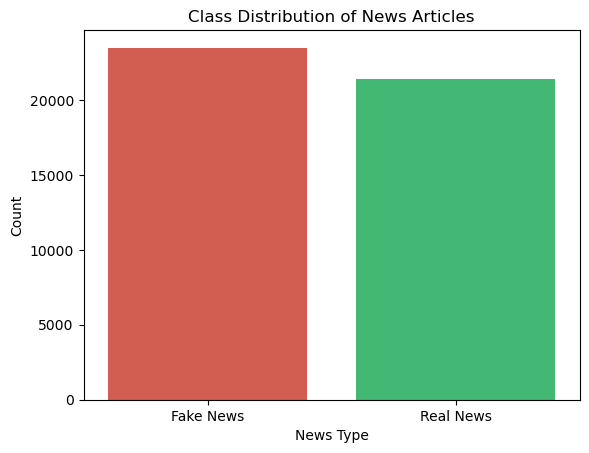

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(
    x="label",
    data=data,
    palette=["#E74C3C", "#2ECC71"]  
)

plt.xticks([0,1], ["Fake News", "Real News"])
plt.title("Class Distribution of News Articles")
plt.xlabel("News Type")
plt.ylabel("Count")
plt.show()


# Model Accuracy Comparison (Decision View)

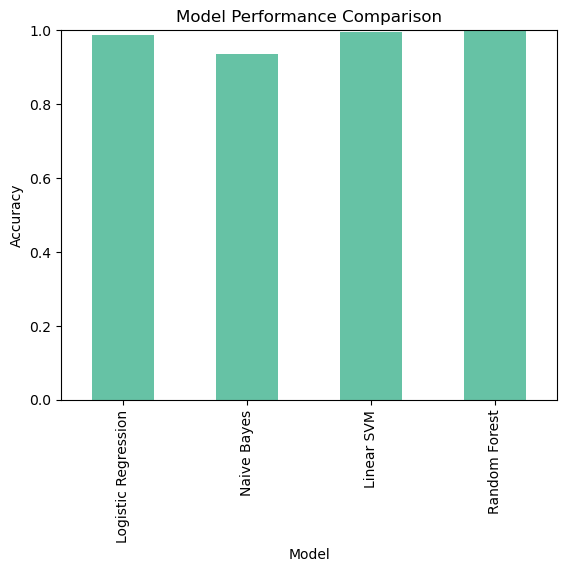

In [34]:
import matplotlib.pyplot as plt

model_results.plot(
    x="Model",
    y="Accuracy",
    kind="bar",
    legend=False,
    colormap="Set2"
)

plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()

# Confusion Matrix

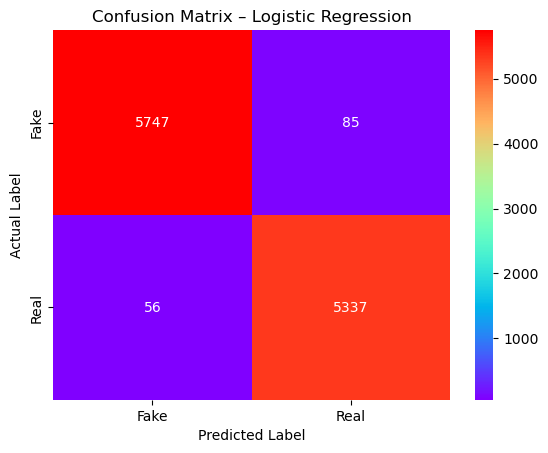

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lr_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="rainbow",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)

plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Explainability Visualization (Top Words)

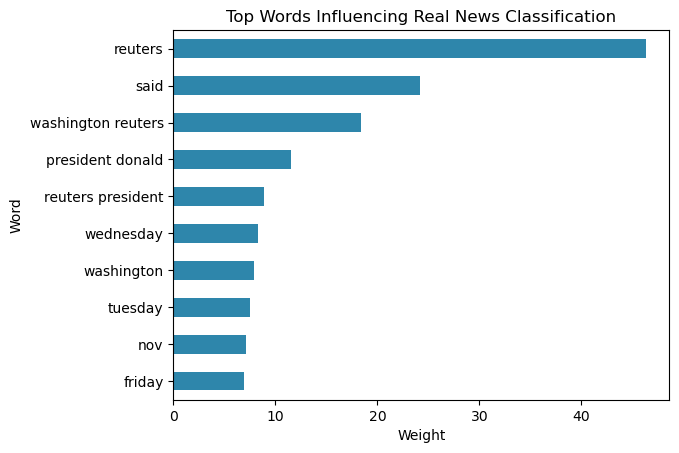

In [39]:
top_features = pd.DataFrame({
    "Word": feature_names[top_real],
    "Coefficient": coefficients[top_real]
})

top_features.plot(
    x="Word",
    y="Coefficient",
    kind="barh",
    legend=False,
    color="#2E86AB"
)

plt.title("Top Words Influencing Real News Classification")
plt.xlabel("Weight")
plt.ylabel("Word")
plt.show()

# Misclassified News Length Analysis

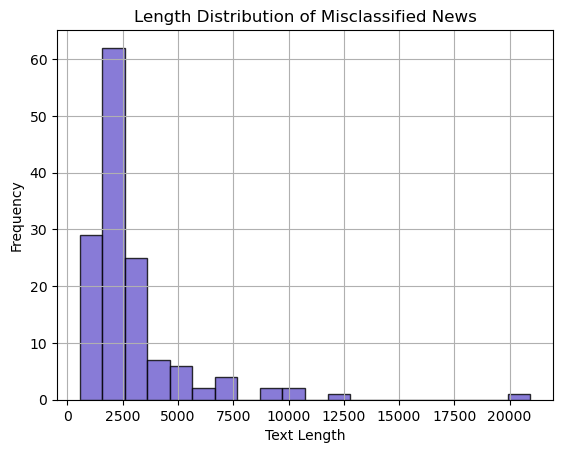

In [41]:
misclassified_texts = X_test[y_test != lr_pred]

misclassified_texts.str.len().hist(
    bins=20,
    color="#6A5ACD",      
    edgecolor="black",   
    alpha=0.8
)

plt.title("Length Distribution of Misclassified News")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

# Cross-Validation Stability Plot

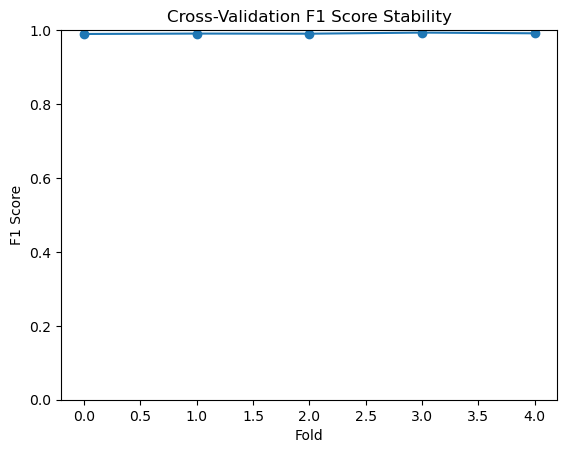

In [43]:
plt.plot(cv_scores, marker='o')
plt.title("Cross-Validation F1 Score Stability")
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.show()

# Prediction Confidence

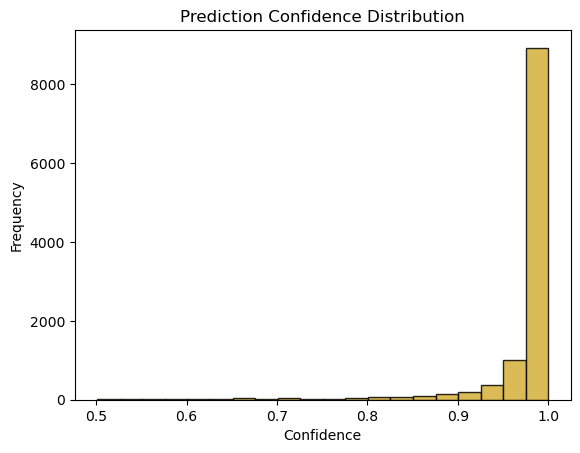

In [46]:
probs = best_model.predict_proba(X_test_tfidf)

plt.hist(
    probs.max(axis=1),
    bins=20,
    color="#D4AF37",      
    edgecolor="black",
    alpha=0.85
)

plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()
